In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import random
import math
from typing import Tuple

In [2]:
# Визуализация активности генов
def plot_gene_dynamics(df, title="Генетическая динамика", genes=None):
    """
    Визуализирует динамику экспрессии генов и энергии клетки, 
    масштабируя энергию так, чтобы её максимум был в 1/4 от максимума по генам.

    Аргументы:
    - df: DataFrame с результатами симуляции
    - title: заголовок графика
    - genes: словарь с ключами - названиями генов, и значениями - цветами линий
             Пример: {"ENGSENS": "blue", "HARVEST": "green"}
    """
    if genes is None:
        genes = {"ENGSENS": "blue", "FOODSENS": "red", "HARVEST": "green", "DIVISION": "purple"}

    # 1) Находим максимум по генам
    max_expr = 0.0
    for g in genes:
        if g in df.columns:
            max_expr = max(max_expr, df[g].max())

    if max_expr == 0:
        scale = 1.0
    else:
        # 2) Находим максимум энергии и считаем scale так,
        # чтобы max_energy*scale = max_expr/4
        max_energy = df["Energy"].max()
        scale = (max_expr / 4) / max_energy if max_energy != 0 else 1.0

    # 3) Создаём фигуру
    fig, ax = plt.subplots(figsize=(12, 6))

    # 4) Масштабированное поле энергии
    ax.fill_between(
        df["Tick"],
        df["Energy"] * scale,
        color="orange", alpha=0.2,
        label=f"Energy (scaled ×{scale:.2f})"
    )

    # 5) Линии активности генов
    for gene, color in genes.items():
        if gene in df.columns:
            ax.plot(df["Tick"], df[gene], label=gene, color=color, linewidth=2)

    # 6) Дополнительные базовые линии
    # ax.axhline(max_expr / 4, color='gray', linestyle=':', linewidth=0.5,
    #            label="Max energy on ¼ of max gene expr")
    ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

    ax.set_title(title)
    ax.set_xlabel("Tick")
    ax.set_ylabel("Уровень (нормировано)")
    ax.legend(loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Работает, добавлена логика гибели клеток из-за дефицита или избытка энергии.

In [4]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    return min(
        expr + 1 if promoter == 'wk' else expr * 2 if promoter == 'av' else expr * 4 if promoter == 'st' else expr, 
        {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    )

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)

def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(max(min(sigma, 3), -8)))  # sigma clamped to avoid infinity effects

def detect_effect(sigma, detect_effect=0.05, k=1):  # sigma clamped to avoid infinity effects
    return (k * np.exp(max(min(sigma, 8), -8))) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Белок веса 150 кДа и более развалится в 4 раза быстрее, чем белок весом 10 кДа
    return (1 if size_kDa <= 10 else 0.25 if size_kDa >= 150 else 0.25 + (150 - size_kDa) / 140.0)

def cell_death_probability(energy: float) -> float:  # Логистическая функция
    x, k, x0 = abs(energy), 3.0, 3.5
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float,
    cell_count: int,
    support_ratio: float
) -> Tuple[dict, dict]:

    for name, (mode, coeff) in cellular_products.items():
        # 1) считаем дельту на одну клетку
        if mode == "energy":
            delta_per_cell = coeff * energy_spent
        elif mode == "TPMsum":
            delta_per_cell = coeff * TPM_sum
        elif mode in prev_status:
            delta_per_cell = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        # 2) масштабируем и по числу клеток, и по загрузке
        # total_delta = delta_per_cell * cell_count * support_ratio
        total_delta = delta_per_cell * support_ratio
        # 3) аккумулируем в env_products
        env_products[name] = env_products.get(name, -3.0) + total_delta

        # 4) обновляем токсичность, если этот продукт токсин
        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + total_delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        
        if not func:
            continue

        ftype, val = func

        # 1) Проверяем, накопился ли белок до порога thr
        if gene_prot[g] < thr:  # Если нет, функция не выполняется вообще
            continue

        # 2) Если накопленного протеина достаточно, запускаем функцию. Все функции теперь получают "eff = gene_prot[g]".  
        eff_prot = gene_prot[g]
        
        if ftype == "energy":
            energy += eff_prot * val

        elif ftype == "process":
            to_proc, rem = eff_prot, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            support_ratio = state["cell_count"] / state["support_cell_num"]
            detox_power   = (eff_prot * state["cell_count"]) * val * support_ratio
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        elif ftype == "mutsens":
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        elif ftype == "mutrep" and state.get("mut_detected", False):
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    new_genes = copy.deepcopy(all_genes)
    for g in new_genes:
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue
        if random.random() < mutation_chance:
            new_genes[g] = mutate_gene(new_genes[g])
    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]
    cell_count      = state["cell_count"]
    support_level   = state["support_cell_num"]
    support_ratio   = cell_count / support_level

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    support_ratio = cell_count / state["support_cell_num"]
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum,
        cell_count, support_ratio
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Expression
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein dynamics
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        # читаем вес из all_genes[g][4]:
        size_kDa = state["all_genes"][g][4]
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Выполнение функций (теперь на основе накопленного gene_prot):
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Применяем гибель клеток
    death_prob = cell_death_probability(energy)
    current = state["cell_count"]
    if current <= 100:
        survived = sum(random.random() >= death_prob for _ in range(current))
    else:
        survived = int(current * (1-death_prob))
    state["cell_count"] = survived

    # 14. Division logic
    if division_happened:
        # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]    = 1
            new_status[g]  = "inactive"
            gene_prot[g]   = 0.0
            deact_delay[g] = False
        toxin_detected = False
        state["cell_count"] *= 2

    # 15. Условие остановки и окончательное число клеток
    survivors = state["cell_count"]
    stop = (survivors == 0) or (energy <= -3)

    # 16. Final energy count
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 17. Формируем запись и следующий стейт только один раз
    record = {
        "Food":         round(food, 2),
        **{n: round(v, 3) for n, v in env_products.items()},
        **{n: round(tox_levels[n], 3) for n in tox_levels},
        "Energy":       round(energy, 2),
        "CellCount":    survivors,
        "mut_detected": state["mut_detected"],
        "tox_detected": toxin_detected,
        **new_expr,
    }

    next_state = {
        "all_genes":       all_genes,
        "gene_list":       gene_list,
        "gene_expr":       new_expr,
        "gene_status":     new_status,
        "gene_prot":       gene_prot,
        "deact_delay":     deact_delay,
        "energy":          energy,
        "food":            food,
        "toxin_detected":  toxin_detected,
        "expressed_flag":  new_expressed,
        "mut_detected":    state["mut_detected"],
        "genes":           state["genes"],
        "reference_genome":state["reference_genome"],
        "cell_count":      survivors,
        "support_cell_num":state["support_cell_num"],
    }

    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    initial_cell_num: int = 1,
    support_cell_num: int = 1000,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    state["cell_count"] = initial_cell_num
    state["support_cell_num"] = support_cell_num
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}

    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [5]:
# Добавляем логику гибели клеток при недостатке и избытке энергии

In [6]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=1.0,
    initial_energy=1,
    initial_cell_num=10000,
    support_cell_num=1000,
    energy_cost=0.001,
    mutation_chance=0.0001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin":  ("energy",  0.005),   # 0.01 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.0001),  # 0.0001 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.001 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03),  # 0.03 * TPM of CELLPROD gene (only when CELLPROD active)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.00)),
        "CellProduct": (-3, ("energy", 0.001))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNACTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 150, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.001)),
        "FEED":    (2,  "quan", "st", "st", 50, ["Energy <= -1", "KINFEED == 'active'"], ["Energy >= 0.5", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.002)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0003)),
        "PROTREP":    (4,  "quan", "st", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.0005)),
        "DETOX":   (2,  "quan", "av", "av", 25, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 15, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2.5", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], False),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNACTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.999,-2.979,-3.000,-3.000,-2,-2,0.94,9994,False,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,3.945667,1.0,0
1,1.0,-2.998,-2.950,-3.000,-3.000,-2,-2,0.86,9989,False,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,15.568283,1.0,1
2,1.0,-2.995,-2.895,-3.000,-3.000,-2,-2,0.77,9985,False,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,15.782663,1.0,2
3,1.0,-2.992,-2.832,-3.000,-3.000,-2,-2,0.66,9982,False,...,1.000000,1.000000,1.000000,1.000000,1.0,1.972833,1.0,15.782660,1.0,3
4,1.0,-2.987,-2.749,-3.000,-3.000,-2,-2,0.55,9980,False,...,1.000000,1.000000,1.000000,1.000000,1.0,3.892067,1.0,15.782657,1.0,4
5,1.0,-2.983,-2.663,-3.000,-3.000,-2,-2,0.43,9978,False,...,1.000000,3.945663,1.000000,1.000000,1.0,1.000000,1.0,15.782653,1.0,5
6,1.0,-2.979,-2.578,-3.000,-1.819,-2,-2,0.31,9977,False,...,1.000000,15.568256,1.972831,1.000000,1.0,1.000000,1.0,15.782650,1.0,6
7,1.0,-2.974,-2.479,-3.000,2.841,-2,-2,0.17,9976,False,...,3.945661,1.000000,3.892062,1.972831,1.0,1.972831,1.0,15.782646,1.0,7
8,1.0,-2.969,-2.388,-3.000,3.140,-2,-2,0.02,9975,False,...,15.568241,1.000000,3.945661,3.892060,1.0,3.892060,1.0,15.782642,1.0,8
9,1.0,-2.995,-2.893,-3.000,-3.000,-3,-3,-0.08,9974,False,...,1.000000,3.979885,3.979885,1.000000,1.0,1.000000,1.0,15.919540,1.0,9


In [7]:
df.tail(15)  # Старый - Wastetoxin дошёл до 201.144, клетки - 268435456. Детоксикация не позволяла удалить всё.

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
985,1.0,799465.109,1.598936e+07,4.691356e+08,-3.0,-3,-3,-1.62,885852720500,False,...,62.395888,1.0,3.899743,3.899743,1.000000,1.0,1.0,15.598972,1.0,985
986,1.0,997361.042,1.994728e+07,4.829540e+08,-3.0,-3,-3,-1.72,883745321531,False,...,62.395888,1.0,3.899743,3.899743,1.000000,1.0,1.0,15.598972,1.0,986
987,1.0,1012525.567,2.025057e+07,4.967395e+08,-3.0,-3,-3,-1.71,881680467359,False,...,62.395888,1.0,3.899743,3.899743,1.000000,1.0,1.0,15.598972,1.0,987
988,1.0,1013942.933,2.027892e+07,5.104928e+08,-3.0,-3,-3,-1.63,880061817233,False,...,62.395888,1.0,3.899743,3.899743,1.949872,1.0,1.0,15.598972,1.0,988
989,1.0,1024122.445,2.048251e+07,5.242208e+08,-3.0,-3,-3,-1.50,878991970019,False,...,62.395888,1.0,3.899743,3.899743,3.801999,1.0,1.0,15.598972,1.0,989
990,1.0,1042742.407,2.085491e+07,5.379322e+08,-3.0,-3,-3,-1.33,878372556790,False,...,62.395888,1.0,3.899743,3.899743,3.899743,1.0,1.0,15.598972,1.0,990
991,1.0,1074525.545,2.149057e+07,5.516339e+08,-3.0,-3,-3,-1.13,878047353174,False,...,62.395888,1.0,3.899743,3.899743,3.899743,1.0,1.0,15.598972,1.0,991
992,1.0,1158092.508,2.316191e+07,5.653306e+08,-3.0,-3,-3,-0.89,877888308933,False,...,62.395888,1.0,3.899743,3.899743,3.899743,1.0,1.0,15.598972,1.0,992
993,1.0,1167937.306,2.335880e+07,5.790247e+08,-3.0,-3,-3,-0.60,877817573160,False,...,62.395888,1.0,3.899743,3.899743,3.899743,1.0,1.0,15.598972,1.0,993
994,1.0,1066477.678,2.132961e+07,5.927178e+08,-3.0,-3,-3,-0.30,877788640735,False,...,62.395888,1.0,3.899743,3.899743,3.899743,1.0,1.0,15.598972,1.0,994


In [8]:
df.Energy.min()

-1.82

In [9]:
df.Energy.max()

1.78

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Food,1000.0,1.000000e+00,0.000000e+00,1.000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Wastetoxin,1000.0,5.039951e+04,1.613249e+05,-2.999,-2.509250,5.300400e+01,6.787465e+03,1.167937e+06
CytokineX,1000.0,1.008047e+06,3.226497e+06,-2.979,6.822000,1.117072e+03,1.358063e+05,2.335880e+07
FooMol,1000.0,3.321441e+07,9.807895e+07,-3.000,396.983750,4.106260e+04,5.041174e+06,6.611498e+08
CellProduct,1000.0,-2.714014e+00,2.049259e+00,-3.000,-3.000000,-3.000000e+00,-3.000000e+00,2.720000e+01
Energotoxin,1000.0,-2.991000e+00,9.448771e-02,-3.000,-3.000000,-3.000000e+00,-3.000000e+00,-2.000000e+00
RNAtoxin,1000.0,-2.991000e+00,9.448771e-02,-3.000,-3.000000,-3.000000e+00,-3.000000e+00,-2.000000e+00
Energy,1000.0,-1.551900e-01,1.051144e+00,-1.820,-1.100000,-1.950000e-01,6.100000e-01,1.780000e+00
CellCount,1000.0,5.731955e+10,1.688041e+11,9517.000,485925.250000,8.878879e+07,8.939017e+09,8.900204e+11
ENGSENS,1000.0,1.495541e+01,3.089361e+00,1.000,15.598972,1.559897e+01,1.591811e+01,1.591954e+01


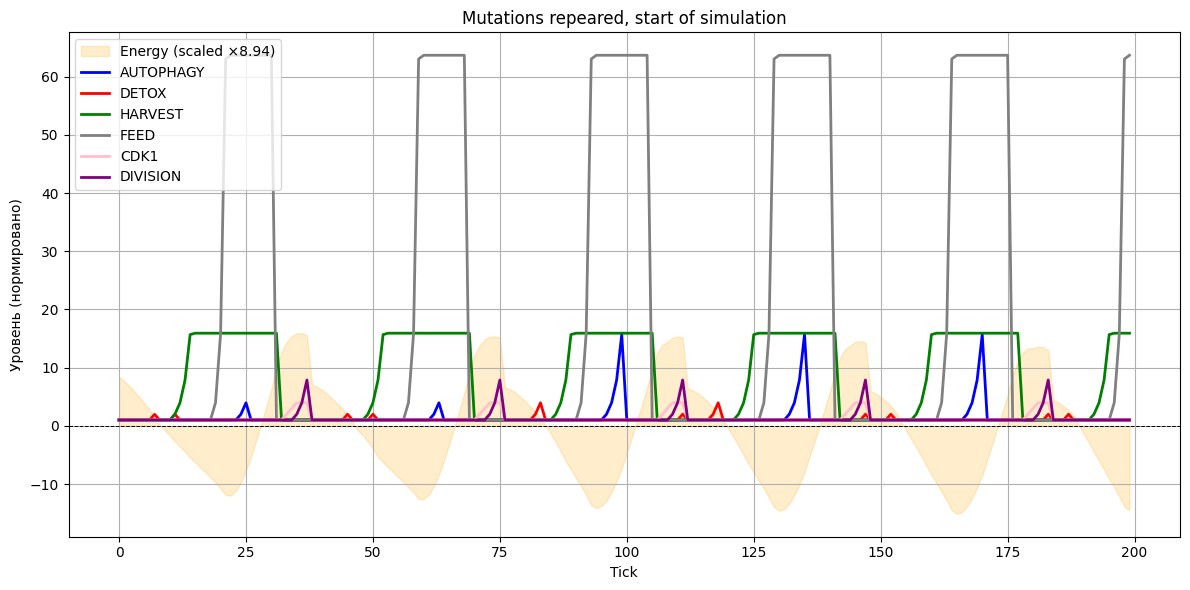

In [11]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "FEED": "gray",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

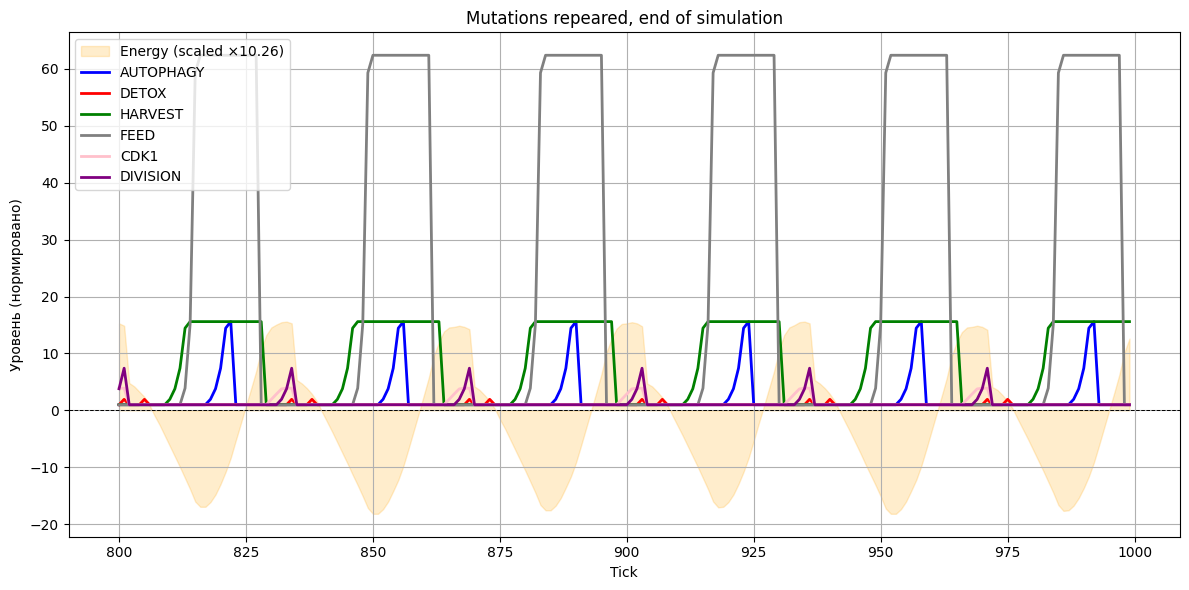

In [12]:
plot_gene_dynamics(df.iloc[-200:, :], title="Mutations repeared, end of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "FEED": "gray",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [13]:
# Тесты из прошлой модели

In [14]:
# Model with heavy mutagenesis
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=10,
    support_cell_num=1000,
    energy_cost=0.002,
    mutation_chance=0.1,
    protein_stability=0.5,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.0))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 150, ["Energy <= -0.25", "FOODSENS == 'active'"], ["Energy >= 0.25", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.05)),
        "FEED":   (2,  "quan", "av", "av", 50, ["Energy <= -2"], ["Energy >= 2", "DIVISION == 'active'"], ("energy", 0.1)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", 50, ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

Cell died at tick 45, energy=5.72


,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,10,False,False,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,10,False,False,16.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.19,10,False,False,16.0,1.0,4.0,1.0,1.0,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.31,10,False,False,16.0,1.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.42,10,True,False,16.0,2.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.54,10,True,False,16.0,4.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.67,10,True,False,16.0,8.0,16.0,2.0,1.0,4.0,1.0,16.0,1.0,6
7,1.0,-2,-0.82,10,True,False,16.0,16.0,16.0,4.0,1.0,4.0,1.0,16.0,1.0,7
8,1.0,-2,-0.83,10,True,False,16.0,16.0,16.0,8.0,1.0,4.0,1.0,16.0,1.0,8
9,1.0,-2,-0.63,10,True,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,9


In [15]:
df.tail(5)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
41,1.0,-2,-2.03,18,True,False,16.0,18.0,16.0,4.0,8.0,64.0,1.0,16.0,1.0,41
42,1.0,-2,-1.17,18,True,False,16.0,19.0,16.0,4.0,16.0,4.0,1.0,16.0,1.0,42
43,1.0,-2,0.74,18,True,False,16.0,16.0,16.0,4.0,16.0,4.0,1.0,16.0,1.0,43
44,1.0,-2,3.16,14,True,False,16.0,16.0,16.0,1.0,16.0,1.0,1.0,16.0,1.0,44
45,1.0,-2,5.72,0,True,False,16.0,1.0,16.0,1.0,1.0,1.0,2.0,16.0,1.0,45


In [16]:
df.mut_detected.value_counts()

mut_detected
True     34
False    12
Name: count, dtype: int64

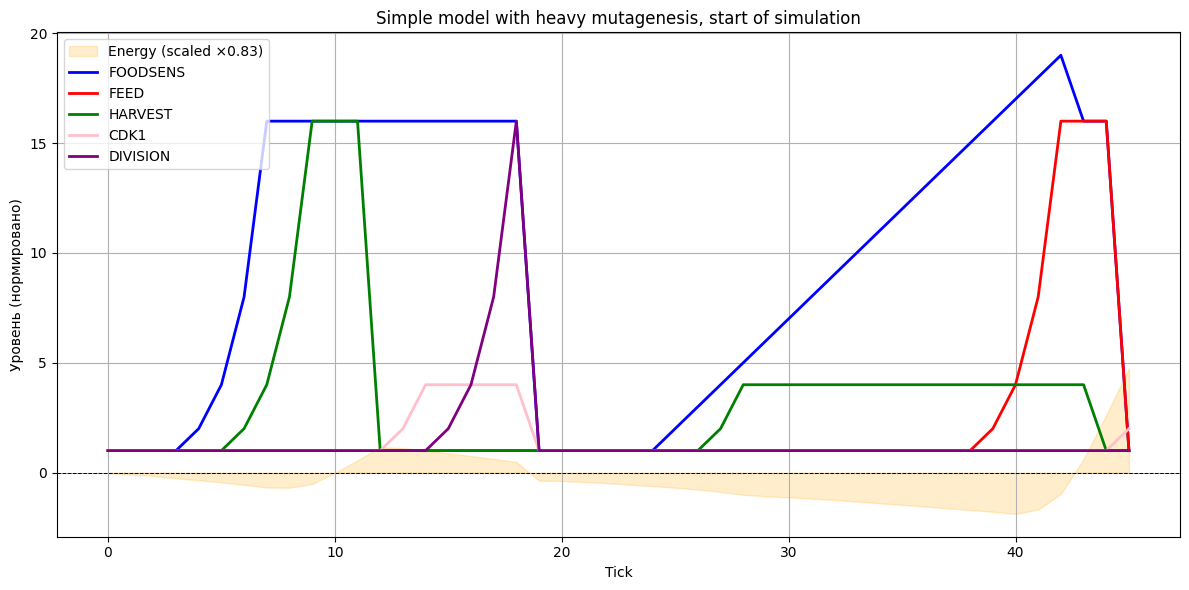

In [17]:
plot_gene_dynamics(df.iloc[:200, :], title="Simple model with heavy mutagenesis, start of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

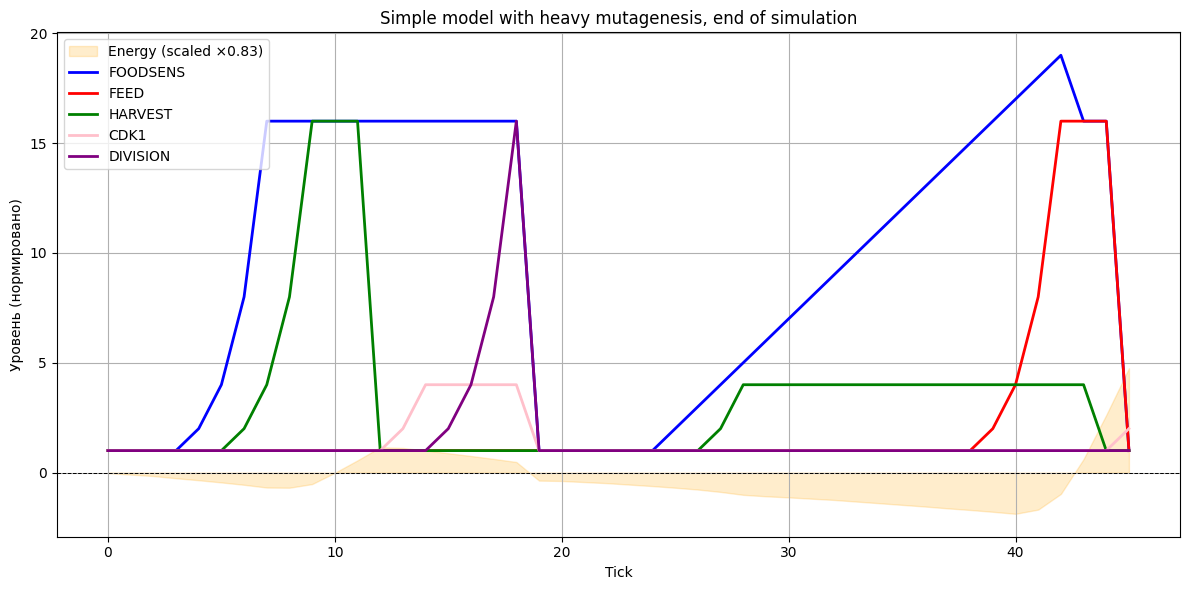

In [18]:
plot_gene_dynamics(df.iloc[-200:, :], title="Simple model with heavy mutagenesis, end of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [19]:
# Model with low mutagenesis
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=10,
    support_cell_num=1000,
    energy_cost=0.002,
    mutation_chance=0.0001,
    protein_stability=0.5,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.0))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 150, ["Energy <= -0.25", "FOODSENS == 'active'"], ["Energy >= 0.25", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.05)),
        "FEED":   (2,  "quan", "av", "av", 50, ["Energy <= -2"], ["Energy >= 2", "DIVISION == 'active'"], ("energy", 0.1)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", 50, ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,10,False,False,4.0,1.0,1.0,1.0,1,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,10,False,False,16.0,1.0,1.0,1.0,1,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.19,10,False,False,16.0,1.0,4.0,1.0,1,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.31,10,False,False,16.0,1.0,16.0,1.0,1,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.42,10,False,False,16.0,2.0,16.0,1.0,1,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.54,10,False,False,16.0,4.0,16.0,1.0,1,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.67,10,False,False,16.0,8.0,16.0,2.0,1,4.0,1.0,16.0,1.0,6
7,1.0,-2,-0.82,10,False,False,16.0,16.0,16.0,4.0,1,4.0,1.0,16.0,1.0,7
8,1.0,-2,-0.83,10,False,False,16.0,16.0,16.0,8.0,1,4.0,1.0,16.0,1.0,8
9,1.0,-2,-0.63,10,False,False,16.0,16.0,16.0,16.0,1,4.0,1.0,16.0,1.0,9


In [20]:
df.tail(5)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
2995,1.0,-2,-0.72,591623307019271929719018220129934639104,False,False,16.0,1.0,4.0,1.0,1,2.0,1.0,16.0,1.0,2995
2996,1.0,-2,-0.83,591483375705892556036212290764354355200,False,False,16.0,1.0,16.0,1.0,1,4.0,1.0,16.0,1.0,2996
2997,1.0,-2,-0.95,591286451542868552533580827843371204608,False,False,16.0,4.0,16.0,1.0,1,4.0,1.0,16.0,1.0,2997
2998,1.0,-2,-1.09,591004329021906599742787478121321857024,False,False,16.0,16.0,16.0,1.0,1,4.0,1.0,16.0,1.0,2998
2999,1.0,-2,-1.24,590570085093992853995783879850761125888,False,False,16.0,16.0,16.0,2.0,1,4.0,1.0,16.0,1.0,2999


In [21]:
df.mut_detected.value_counts()

mut_detected
False    2986
True       14
Name: count, dtype: int64

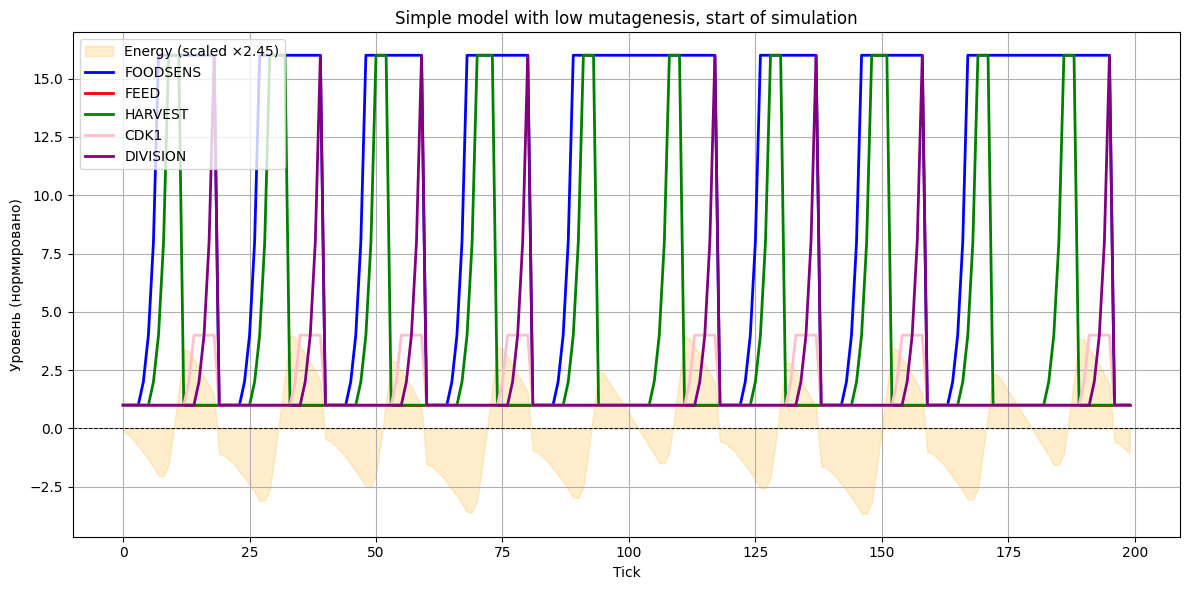

In [22]:
plot_gene_dynamics(df.iloc[:200, :], title="Simple model with low mutagenesis, start of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

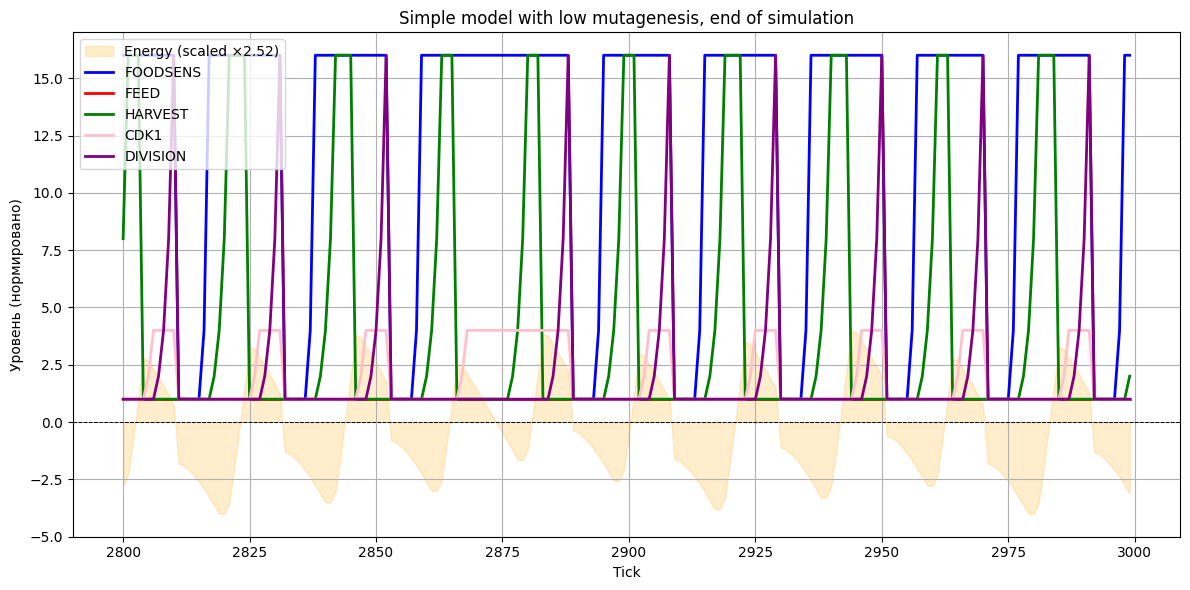

In [23]:
plot_gene_dynamics(df.iloc[-200:, :], title="Simple model with low mutagenesis, end of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [24]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=10,
    support_cell_num=10,
    energy_cost=0.002,
    mutation_chance=0.0001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin":  ("energy",  0.1),   # 0.1 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.0001)),
        "CellProduct": (-3, ("energy", 0.003))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.01)),
        "FEED":    (2,  "quan", "st", "st", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.005)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", 40, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 10, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], False),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

Cell died at tick 15, energy=4.81


,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.996,-2.979,-3.000,-3.0,-2.0,-2.0,-0.08,10,False,...,1,1,1.000000,1.000000,1,1.000000,1.000000,3.945666,1.0,0
1,1.0,-2.990,-2.951,-3.000,-3.0,-2.0,-2.0,-0.21,10,False,...,1,1,1.000000,1.000000,1,1.000000,1.000000,15.568275,1.0,1
2,1.0,-2.980,-2.899,-3.000,-3.0,-2.0,-2.0,-0.36,10,False,...,1,1,1.972831,1.000000,1,1.000000,1.000000,15.782651,1.0,2
3,1.0,-2.968,-2.842,-3.000,-3.0,-2.0,-2.0,-0.53,10,False,...,1,1,3.892061,1.000000,1,1.000000,1.000000,15.782641,1.0,3
4,1.0,-2.954,-2.771,-3.000,-3.0,-2.0,-2.0,-0.70,10,False,...,1,1,3.945657,1.000000,1,1.000000,1.000000,15.782630,1.0,4
5,1.0,-2.939,-2.696,-3.000,-3.0,-2.0,-2.0,-0.89,10,False,...,1,1,3.945654,1.000000,1,1.000000,1.000000,15.782617,1.0,5
6,1.0,-2.921,-2.607,-3.000,-3.0,-2.0,-2.0,-1.11,10,False,...,1,1,3.945650,1.000000,1,1.000000,1.000000,15.782602,1.0,6
7,1.0,-2.894,-2.469,-2.992,-3.0,-2.0,-2.0,-1.07,10,False,...,1,1,3.945644,1.000000,1,1.000000,1.000000,15.782578,1.0,7
8,1.0,-2.864,-2.318,-2.977,-3.0,-2.0,-2.0,-0.82,10,False,...,1,1,3.945638,1.000000,1,1.000000,1.000000,15.782551,1.0,8
9,1.0,-2.833,-2.163,-2.961,-3.0,-2.0,-2.0,-0.35,10,False,...,1,1,3.945630,1.000000,1,1.000000,1.000000,15.782522,1.0,9


In [25]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
11,1.0,-2.768,-1.839,-2.930,-3.0,-2.000,-2.000,1.14,10,False,...,1,1,3.945615,1.000000,1,1.000000,1.000000,15.782459,1.000000,11
12,1.0,-2.734,-1.671,-2.914,-3.0,-2.000,-2.000,2.20,9,False,...,1,1,1.000000,1.972803,1,1.000000,1.000000,15.782424,1.000000,12
13,1.0,-2.706,-1.531,-2.900,-3.0,-2.000,-2.000,3.39,4,False,...,1,1,1.000000,3.891945,1,1.000000,1.972799,15.782395,1.000000,13
14,1.0,-2.699,-1.495,-2.899,-3.0,-2.000,-2.000,4.23,1,False,...,1,1,1.000000,3.945597,1,1.972798,2.932367,15.782387,1.000000,14
15,1.0,-2.756,-1.544,-2.899,-3.0,-2.059,-2.059,4.81,0,False,...,1,1,1.000000,3.948722,1,3.895016,3.881956,15.794887,1.974361,15


In [26]:
df.mut_detected.value_counts()

mut_detected
False    16
Name: count, dtype: int64

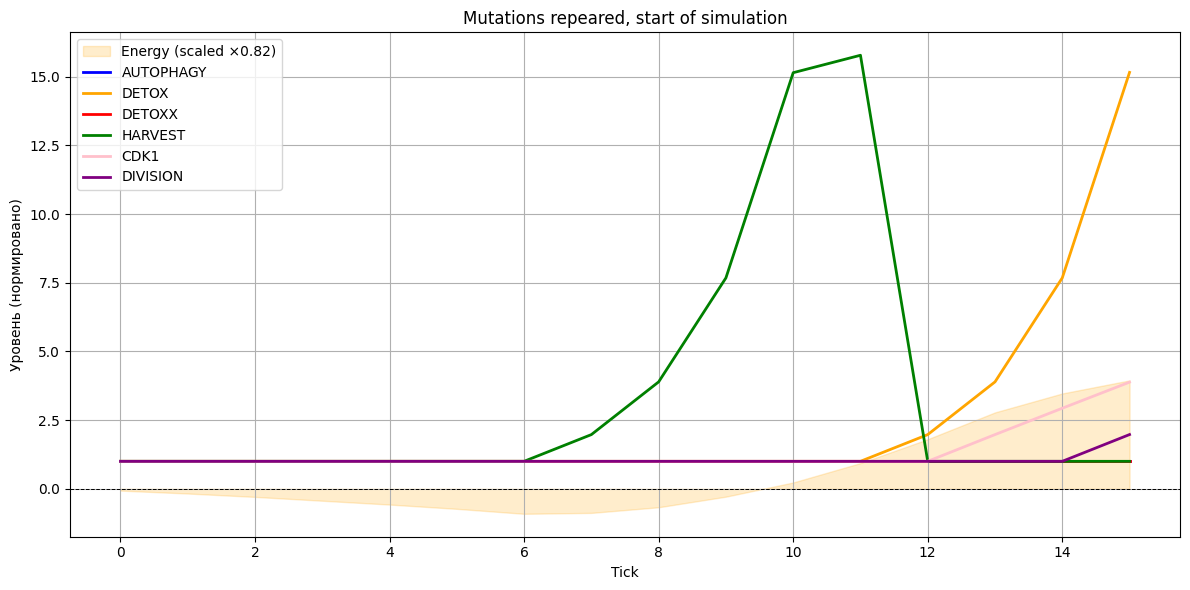

In [27]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

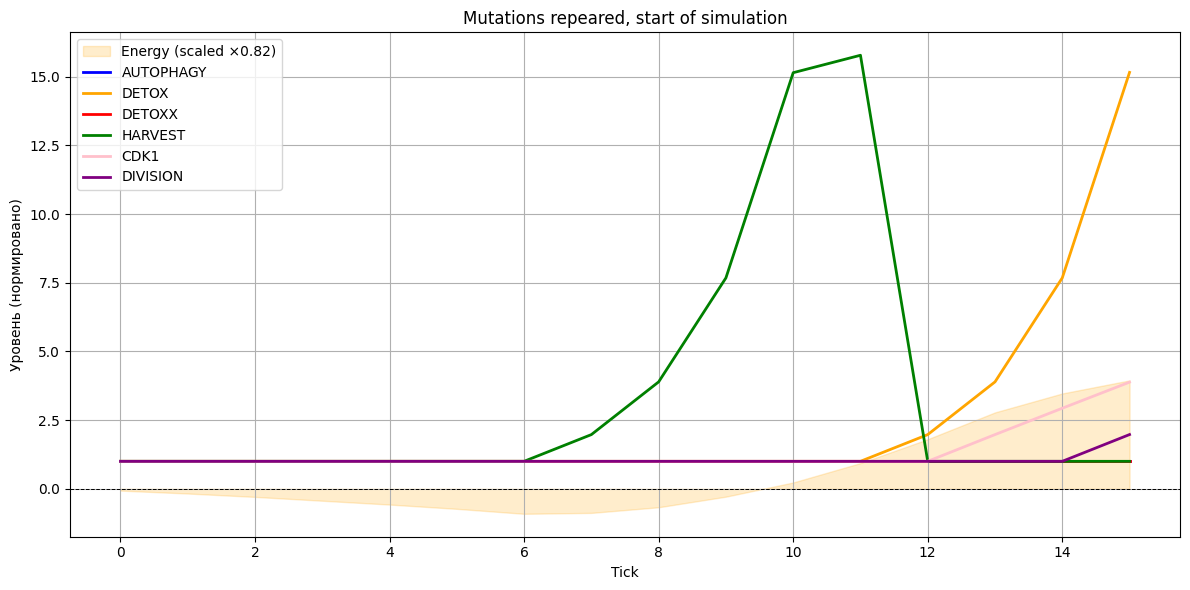

In [28]:
plot_gene_dynamics(df.iloc[-200:, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [29]:
df.tail(35)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.996,-2.979,-3.000,-3.0,-2.000,-2.000,-0.08,10,False,...,1,1,1.000000,1.000000,1,1.000000,1.000000,3.945666,1.000000,0
1,1.0,-2.990,-2.951,-3.000,-3.0,-2.000,-2.000,-0.21,10,False,...,1,1,1.000000,1.000000,1,1.000000,1.000000,15.568275,1.000000,1
2,1.0,-2.980,-2.899,-3.000,-3.0,-2.000,-2.000,-0.36,10,False,...,1,1,1.972831,1.000000,1,1.000000,1.000000,15.782651,1.000000,2
3,1.0,-2.968,-2.842,-3.000,-3.0,-2.000,-2.000,-0.53,10,False,...,1,1,3.892061,1.000000,1,1.000000,1.000000,15.782641,1.000000,3
4,1.0,-2.954,-2.771,-3.000,-3.0,-2.000,-2.000,-0.70,10,False,...,1,1,3.945657,1.000000,1,1.000000,1.000000,15.782630,1.000000,4
5,1.0,-2.939,-2.696,-3.000,-3.0,-2.000,-2.000,-0.89,10,False,...,1,1,3.945654,1.000000,1,1.000000,1.000000,15.782617,1.000000,5
6,1.0,-2.921,-2.607,-3.000,-3.0,-2.000,-2.000,-1.11,10,False,...,1,1,3.945650,1.000000,1,1.000000,1.000000,15.782602,1.000000,6
7,1.0,-2.894,-2.469,-2.992,-3.0,-2.000,-2.000,-1.07,10,False,...,1,1,3.945644,1.000000,1,1.000000,1.000000,15.782578,1.000000,7
8,1.0,-2.864,-2.318,-2.977,-3.0,-2.000,-2.000,-0.82,10,False,...,1,1,3.945638,1.000000,1,1.000000,1.000000,15.782551,1.000000,8
9,1.0,-2.833,-2.163,-2.961,-3.0,-2.000,-2.000,-0.35,10,False,...,1,1,3.945630,1.000000,1,1.000000,1.000000,15.782522,1.000000,9


In [30]:
# Цели на следующий этап
# Эффективность переработки Food среды в энергию. Растёт при большем значении Food, падает при меньшем.
# Выработку пищи в среде, +1 за каждый такт
# Потребление энергии клетки, которое рассчитывается как 1 для количества всех генов * на 16

In [31]:
# Токсины и продукты выделяются
# Токсины травят, но их эффект пришлось обрезать
# Детекцию токсинов также пришлось обрезать, поскольку слишком большие сигма приводят к бесконеным эффектам
# Детекция мутагенеза, сам мутагенез и репарация работают
# Функции белков отвязаны от единиц экспрессии генов, и привязаны к единицам собственно белков
# Белки могут разваливаться
# Гибель клеток как функцию вероятности
# Гибель при избытке энергии
# ХОТЬ СЕЙЧАС В ПРОДАКШ!
#
# Осталось реализовать
# Фосфорилирование
# Выработку пищи в среде, +1 за каждый такт
# Потребление энергии клетки, которое рассчитывается как 1 для количества всех генов * на 16
# Эффективность переработки Food среды в энергию. Растёт при большем значении Food, падает при меньшем.
# Метилирование, при 0 - активность экспрессии *2, при 1 - активность экспресии *0.
# Ген деметилируется, скажем, на 0.2 при попытке начать экспресию, а при делении - метилируется на 0.25.
# Шапероны малого размера, которые таргетируют белки по их именам, и предохраняют их от развала, придавая им преиущества стабильности
# Лёгкий мутагенез, связанный с изменением величины эффекта
# Тяжёлый мутагенез, связанный с хромосомными перестройками и химерными генами